In [1]:
import collections.abc
import os
from pathlib import Path

import numpy as np
from pptx import Presentation
from pptx.enum.text import PP_ALIGN
from pptx.util import Cm, Inches, Pt

# レイアウトを確認する
各スライドのshapeのインデックスと位置を確認するためにサンプルスライドを作成します。

In [2]:
def output_sample(
    template_pptx_path: Path,
    output_path: Path = Path("インデックス確認用サンプル.pptx"),
):
    """レイアウト確認用の出力サンプルを作成する

    Args:
        template_pptx_path (Path): パワーポイントテンプレートのパス
        output_path (Path, optional): 出力先のパス. Defaults to "インデックス確認用サンプル.pptx".
    """
    ppt = Presentation(template_pptx_path)

    for i, li in enumerate(ppt.slide_layouts):
        slide_i = ppt.slides.add_slide(li)
        for i, si in enumerate(slide_i.shapes):
            si.text = f"{i}番目のshape"

    pt_chack_page = ppt.slides.add_slide(ppt.slide_layouts[-1])
    width = height = Pt(100)
    for i in np.arange(0, 1000, 100):
        left_i = Pt(i)
        for j in np.arange(0, 600, 100):
            top_j = Pt(j)
            pt_chack_page.shapes.add_textbox(left_i, top_j, width, height)
            textbox = pt_chack_page.shapes.add_textbox(left_i, top_j, width, height)
            tf = textbox.text_frame
            tf.text = f"left={i}pt\ntop={j}pt"

    from pptx.text.fonts import FontFiles

    fs = FontFiles._installed_fonts()
    ft_chack_page = ppt.slides.add_slide(ppt.slide_layouts[-1])
    text_frame = ft_chack_page.shapes.add_textbox(
        Pt(0), Pt(0), Pt(100), Pt(10)
    ).text_frame

    for i, fi in enumerate(set(k[0] for k in fs.keys())):
        p = text_frame.add_paragraph()
        p.text = f"{fi} ABCDE 12345 あいうえお 日本東京京都 !?+-="
        p.font.name = fi

    ppt.save(output_path)

In [3]:
from IPython.display import IFrame

output_sample("pptx-template\\main.pptx")
IFrame("インデックス確認用サンプル.pdf", width=600, height=300)

# パワーポイント作成例

In [4]:
from datetime import datetime as dt


class PptxSlide:
    def __init__(self, ppt: Presentation, title: str, layout_no: int):
        """パワーポイントスライド

        Args:
            ppt (Presentation): Presentation
            title (str): タイトル
            layout_no (int): レイアウト番号
        """
        self.ppt = ppt
        self.title = title
        self.subtitle = "サブタイトル"
        self.pagenum = 1
        self.layout_no = layout_no
        self.layout = ppt.slide_layouts[layout_no]
        self.slide = self.ppt.slides.add_slide(self.layout)

        # スライドの初期化
        self.slide.shapes.title.text = self.title

    def set_title(self, title: str):
        self.slide.shapes.title.text = title

    def save_pptx(self, filename: Path, savedir: Path = Path("output")):
        os.makedirs(savedir, exist_ok=True)
        pptx_savepath = os.path.join(savedir, f"{filename}.pptx")

        try:
            self.ppt.save(pptx_savepath)
        except PermissionError:
            print(
                "PermissionErrorが発生しました。ほとんどの場合、これはパワーポイントが開かれているために発生します。"
            )
            print(f"{pptx_savepath}を閉じた上でもう一度実行してください。")

## タイトルページ

In [5]:
class TitlePage(PptxSlide):
    def __init__(self, ppt: Presentation, title: str, subtitle: str = ""):
        """タイトルページ

        Args:
            ppt (Presentation): Presentation
            title (str): タイトル
            subtitle (str, optional): サブタイトル. Defaults to "".
        """
        super().__init__(ppt, title, 0)
        self.set_subtitle(subtitle)
        self.set_date()

    def set_subtitle(self, subtitle: str):
        """サブタイトルを設定する

        Args:
            subtitle (str): サブタイトルテキスト
        """
        self.slide.placeholders[1].text = subtitle

    def set_date(self):
        """ファイル作成日を設定する"""
        self.slide.shapes[2].text = dt.now().strftime("%Y/%m/%d")

    def set_conference_name(self, conference_name: str):
        """学会名を設定する

        Args:
            conference_name (str): 学会名
        """
        self.slide.shapes[3].text = conference_name


# ベースとなるパワーポイントファイル
ppt = Presentation("pptx-template/main.pptx")

# タイトルページ
title_page = TitlePage(ppt, "タイトルです", subtitle="サブタイトルです")
title_page.set_conference_name("あいうえお学会")
title_page.save_pptx("サンプル１")

## 画像を載せる

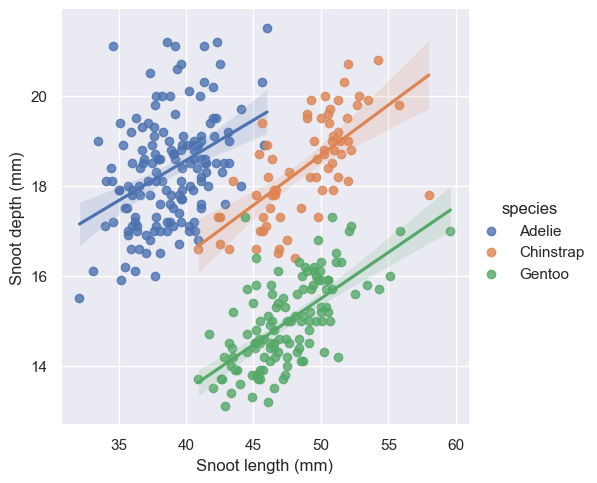

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

penguins = sns.load_dataset("penguins")

g = sns.lmplot(
    data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", height=5
)
g.set_axis_labels("Snoot length (mm)", "Snoot depth (mm)")

img_save_path = "output/sampleimg1.png"
plt.savefig(img_save_path, dpi=200)

In [7]:
class ImgDescriptionPage(PptxSlide):
    def __init__(self, ppt: Presentation, title: str, subtitle: str = ""):
        """画像説明ページ

        Args:
            ppt (Presentation): Presentation
            title (str): タイトル
            subtitle (str, optional): サブタイトル. Defaults to "".
        """
        super().__init__(ppt, title, 1)
        self.set_subtitle(subtitle)

    def set_subtitle(self, subtitle: str):
        """サブタイトルを設定する

        Args:
            subtitle (str): サブタイトルテキスト
        """
        self.slide.placeholders[1].text = subtitle

    def set_picture(self, img_path: Path):
        """画像を設定する

        Args:
            img_path (Path): 画像が保存されているパス
        """
        self.slide.shapes.add_picture(
            img_path, left=Pt(600), top=Pt(100), width=Pt(270), height=Pt(270)
        )

    def set_header_text(self, text: str):
        """ヘッダーのテキストを設定する

        Args:
            text (str): ヘッダーのテキスト
        """
        self.slide.shapes[2].text = text


# ベースとなるパワーポイントファイル
ppt = Presentation("pptx-template/main.pptx")

# タイトルページ
title_page = TitlePage(ppt, "タイトルです", subtitle="サブタイトルです")
title_page.set_conference_name("あいうえお学会")

# 画像を説明するページ
second_page = ImgDescriptionPage(
    ppt, "2ページ目のタイトル", subtitle="2ページ目のサブタイトル"
)
second_page.set_picture(img_save_path)
second_page.set_header_text("これはページ上部のちいさい文字列")
title_page.save_pptx("サンプル２")